In [1]:
import sys,os
sys.path.append('../..')
from backtester import matlab, backtester
from backtester.analysis import *
import pandas as pd
import numpy as np
import scipy

%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
strategyname = 'strategy_270225'
d, info = matlab.loaddata('../../mat/'+strategyname+'.mat')


In [96]:
d_slice=d.ix['2000':]

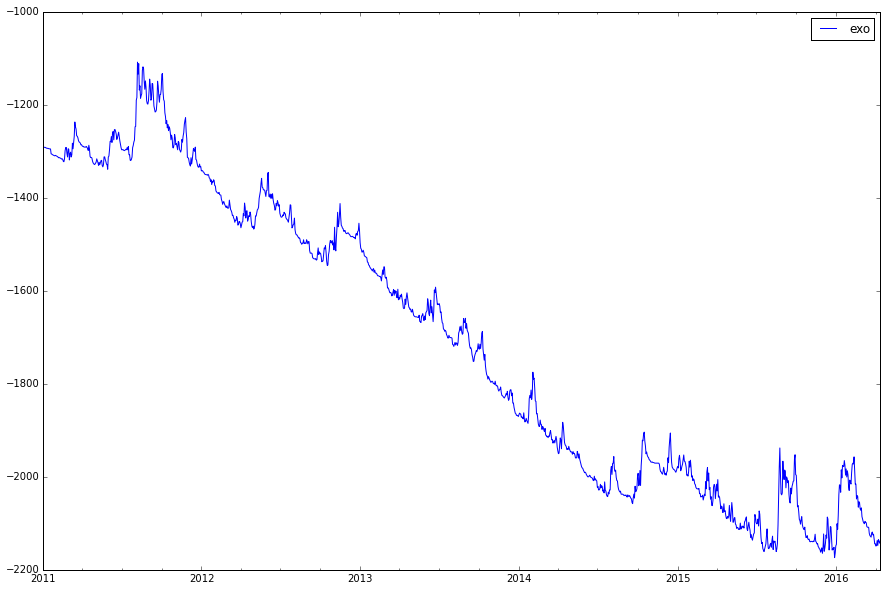

In [97]:
d_slice.plot()

In [98]:
info

{'legs': 4,
 'name': 'BearishCollarBrokenWing',
 'pcf': array([1, 2, 0, 1], dtype=uint8),
 'pcfqty': array([-1, -1,  1,  1], dtype=int16),
 'tickincrement': 0.25,
 'tickvalue': 12.5,
 'underlying': 'EP'}

# Simple entry and exit rules based on MA crossing

{'count': 44, 'winrate': 0.6136363636363636, 'avg': 2.9034090909091219, 'std': 34.460897467814021, 'maxdd': -295.14999999999964, 'netprofit': 127.75000000000136}


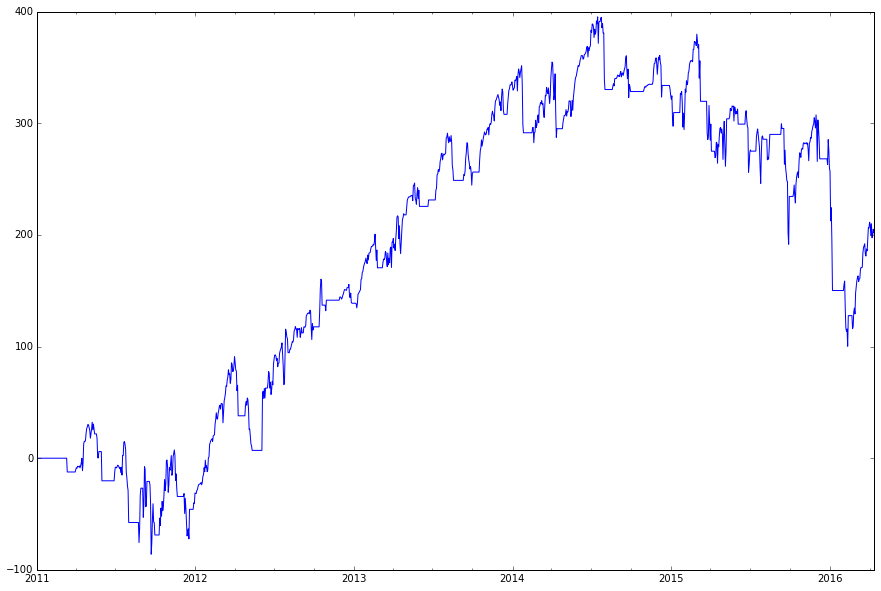

In [99]:
#Defining entry\exit rules
slow_ma = d_slice.exo.rolling(15).mean()#try period == 5
fast_ma = d_slice.exo.rolling(10).mean()#try period == 6


short_entry = CrossDown(fast_ma, slow_ma)
short_exit = (CrossUp(fast_ma, slow_ma)) 

direction = -1
pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
equity, stats = backtester.stats(pl, inposition)


print(stats)
equity.plot()

# Trailing stop exploration

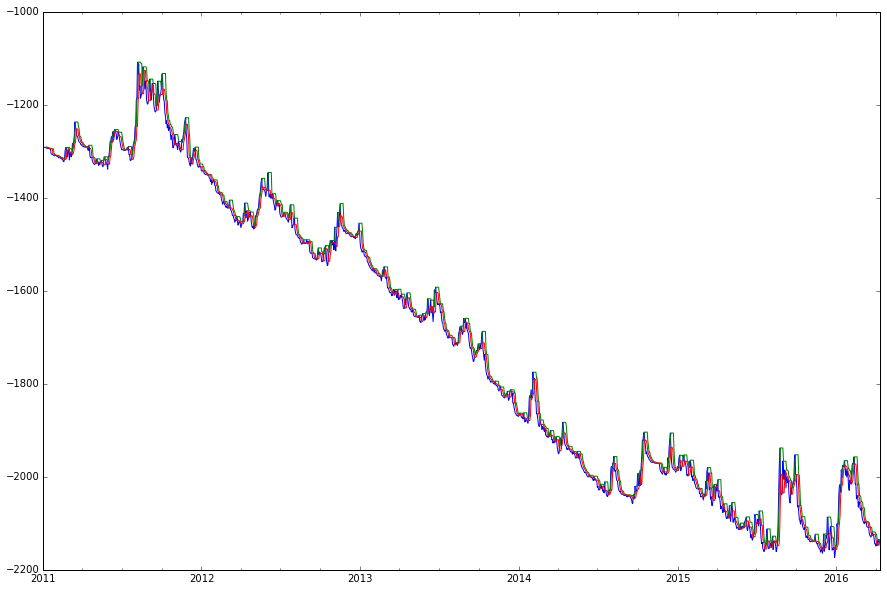

In [100]:
figsize(15, 10)


#Trailing stop works better on trending markets.
#On markets where mean-reversion regime prevails, TS will not performing well.
#We need to determine size of TS according to underlying volatility. It will help us to not lose too much on volatility bursts

#Rolling max\min works quite well for raw exploration. Period of rolling window is a subject of optimization
period=5
trailing_stop_short =d_slice.exo.rolling(period).max().shift(1)
trailing_stop_long = d_slice.exo.rolling(period).min().shift(1)

#Simple vola metric. Based on previous px change
# Median smoothing unlike averaging, is less resposive to volatility busts
# I think is will be more useful in our case
vola=d_slice.exo.shift(1)-d_slice.exo.shift(2)
volatility_metric=abs(vola.rolling(10).median())

d_slice.exo.plot()
#slow_ma.plot(c='r')
#fast_ma.plot(c='g')
trailing_stop_short.plot()


#We need to define stop size for median trailing. It must be either fixed value or dynamic value which adjusted by volatility
median_trailstop=d_slice.exo.rolling(5).median().shift(1)
median_trailstop.plot()

C:\Anaconda3\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


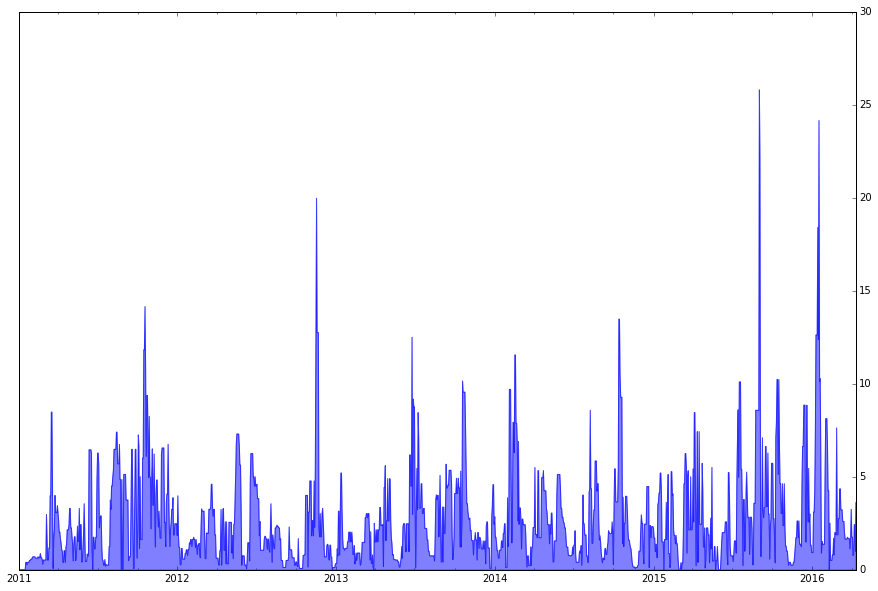

In [101]:
volatility_metric.plot(secondary_y=True,kind='area',stacked=False)

# Optimizing

### Rolling max trailing

In [102]:
#We're going to optimize period of rolling windows and compare system perfomance  results
#Index of DF is optimizing parameter value

results_a=[]
results_index_a=[]
for p in range(5,200,5):
    optimizing_period=p
    trailing_stop_short =d_slice.exo.rolling(optimizing_period).max().shift(1) 

    short_entry = CrossDown(fast_ma, slow_ma)
    short_exit = (CrossUp(fast_ma, slow_ma)) | (CrossUp(d_slice.exo,trailing_stop_short))

    direction = -1
    pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
    equity, stats = backtester.stats(pl, inposition)



    results_a.append(stats)
    results_index_a.append(p)


In [103]:
rollingmax_results_df=pd.DataFrame(results_a,index=results_index_a)

In [104]:
rollingmax_results_df.sort(['netprofit'],ascending=False)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,avg,count,maxdd,netprofit,std,winrate
5,6.570213,47,-107.75,308.80,22.878097,0.617021
40,3.500000,44,-253.20,154.00,32.399434,0.613636
20,3.468182,44,-306.35,152.60,34.224687,0.613636
15,3.448864,44,-327.50,151.75,35.466052,0.613636
55,3.300000,44,-262.00,145.20,32.175818,0.613636
50,3.300000,44,-262.00,145.20,32.175818,0.613636
45,3.300000,44,-262.00,145.20,32.175818,0.613636
60,3.300000,44,-262.00,145.20,32.175818,0.613636
180,2.903409,44,-295.15,127.75,34.460897,0.613636
185,2.903409,44,-295.15,127.75,34.460897,0.613636


C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: pd.rolling_max is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,window=5).max()
  from ipykernel import kernelapp as app


{'count': 47, 'winrate': 0.6170212765957447, 'avg': 6.5702127659574696, 'std': 22.878096603739767, 'maxdd': -107.74999999999955, 'netprofit': 308.80000000000109}


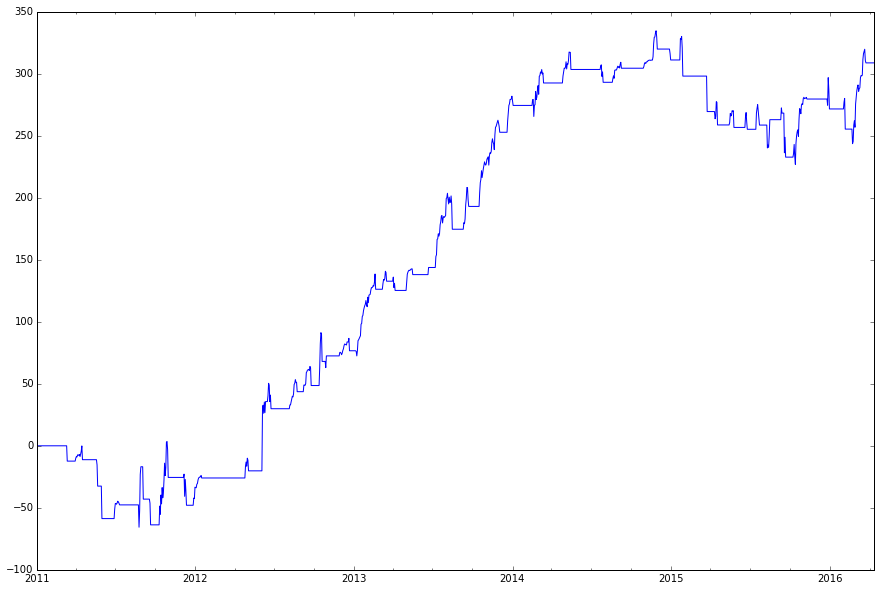

In [105]:
optimizing_period=5
trailing_stop_short = pd.rolling_max(d_slice.exo,optimizing_period).shift(1)

short_entry = CrossDown(fast_ma, slow_ma)
short_exit = (CrossUp(fast_ma, slow_ma)) | (CrossUp(d_slice.exo,trailing_stop_short))

direction = -1
pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
equity, stats = backtester.stats(pl, inposition)

print(stats)
equity.plot()    

#Seems good

In [109]:
#We're going to optimize period of rolling windows, size of TS and compare systems perfomance  results
#Index of DF is optimizing parameter value

results_a=[]
results_index_a=[]
results_vola_optimization_a=[]

vola=d_slice.exo.shift(1)-d_slice.exo.shift(2)
volatility_metric=abs(vola.rolling(5).median())

for p in range(5,200,5):
    optimizing_period=p
    trailing_stop_short = d_slice.exo.rolling(optimizing_period).max().shift(1)
    
    for v in np.arange(0,2,0.1):
        vola_multiplier=v     
        
        trailing_stop_dynamicsize_short=trailing_stop_short+(volatility_metric*vola_multiplier)
        
        short_entry = CrossDown(fast_ma, slow_ma)
        short_exit = (CrossUp(fast_ma, slow_ma)) | (CrossUp(d_slice.exo,trailing_stop_dynamicsize_short))

        direction = -1
        pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
        equity, stats = backtester.stats(pl, inposition)

        results_a.append(stats)
        results_index_a.append(p)
        results_vola_optimization_a.append(vola_multiplier)

In [110]:
rollingmax_dynamicsized_results_df=pd.DataFrame(results_a,index=[results_index_a,results_vola_optimization_a])

In [111]:
rollingmax_dynamicsized_results_df.sort('netprofit',ascending=False)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


avg  count   maxdd  netprofit        std   winrate
5  0.2  7.751064     47 -107.75     364.30  24.979806  0.617021
   0.3  7.539362     47 -112.75     354.35  25.144019  0.617021
   0.4  7.539362     47 -112.75     354.35  25.144019  0.617021
   0.7  6.662766     47 -154.40     313.15  26.119495  0.617021
   0.8  6.662766     47 -154.40     313.15  26.119495  0.617021
   0.9  6.662766     47 -154.40     313.15  26.119495  0.617021
   1.0  6.662766     47 -154.40     313.15  26.119495  0.617021
   0.5  6.653191     47 -154.40     312.70  26.160394  0.617021
   1.4  6.584043     47 -190.10     309.45  28.440414  0.617021
   0.0  6.570213     47 -107.75     308.80  22.878097  0.617021
   0.1  6.570213     47 -107.75     308.80  22.878097  0.617021
   0.6  6.536170     47 -154.40     307.20  26.173116  0.617021
   1.3  5.963830     47 -190.10     280.30  28.233558  0.617021
   1.1  5.573404     47 -185.25     261.95  27.539399  0.617021
   1.2  5.435106     47 -190.10     255.45  28.215284  0.595745
   1.5  5.397872     47 -190.10     253.70  29.722776  0.617021
   1.6  4.508511     47 -216.40     211.90  30.786992  0.617021
15 0.7  3.905682     44 -301.80     171.85  35.715874  0.613636
   0.9  3.905682     44 -301.80     171.85  35.715874  0.613636
   0.8  3.905682     44 -301.80     171.85  35.715874  0.613636
   1.4  3.740909     44 -301.80     164.60  35.738004  0.590909
   1.3  3.740909     44 -301.80     164.60  35.738004  0.590909
   1.2  3.740909     44 -301.80     164.60  35.738004  0.590909
   1.1  3.740909     44 -301.80     164.60  35.738004  0.590909
5  1.7  3.373404     47 -269.75     158.55  33.305964  0.617021
   1.8  3.373404     47 -269.75     158.55  33.305964  0.617021
   1.9  3.373404     47 -269.75     158.55  33.305964  0.617021
40 0.0  3.500000     44 -253.20     154.00  32.399434  0.613636
   0.3  3.500000     44 -253.20     154.00  32.399434  0.613636
   0.2  3.500000     44 -253.20     154.00  32.399434  0.613636
...          ...    ...     ...        ...        ...       ...
25 0.5  1.678409     44 -332.80      73.85  35.777074  0.568182
   0.6  1.678409     44 -332.80      73.85  35.777074  0.568182
20 1.1  1.637500     44 -375.65      72.05  37.792019  0.568182
30 0.7  1.636364     44 -327.45      72.00  35.822786  0.568182
   0.8  1.636364     44 -327.45      72.00  35.822786  0.568182
   0.5  1.636364     44 -327.45      72.00  35.822786  0.568182
   0.4  1.636364     44 -327.45      72.00  35.822786  0.568182
   0.6  1.636364     44 -327.45      72.00  35.822786  0.568182
20 1.5  1.072727     44 -375.65      47.20  38.224712  0.590909
   1.0  0.893182     44 -375.65      39.30  38.227536  0.568182
10 1.5 -0.857778     45 -405.35     -38.60  34.062128  0.555556
   1.6 -1.018889     45 -405.35     -45.85  33.842361  0.555556
   1.7 -1.018889     45 -405.35     -45.85  33.842361  0.555556
   0.0 -1.276087     46 -393.60     -58.70  32.945683  0.586957
   0.1 -1.276087     46 -393.60     -58.70  32.945683  0.586957
   1.4 -1.386667     45 -405.35     -62.40  34.406300  0.555556
   0.3 -1.743478     46 -403.45     -80.20  33.170293  0.565217
   0.2 -1.743478     46 -403.45     -80.20  33.170293  0.565217
   1.3 -1.942222     45 -430.35     -87.40  33.423970  0.533333
   1.2 -1.942222     45 -430.35     -87.40  33.423970  0.533333
   1.8 -2.016667     45 -450.25     -90.75  36.509614  0.555556
   1.9 -2.016667     45 -450.25     -90.75  36.509614  0.555556
   1.1 -2.376667     45 -420.30    -106.95  33.375696  0.533333
   0.8 -2.376667     45 -420.30    -106.95  33.375696  0.533333
   0.9 -2.376667     45 -420.30    -106.95  33.375696  0.533333
   1.0 -2.376667     45 -420.30    -106.95  33.375696  0.533333
   0.4 -2.402174     46 -403.45    -110.50  33.012586  0.543478
   0.5 -2.451087     46 -403.45    -112.75  32.999691  0.543478
   0.6 -2.451087     46 -403.45    -112.75  32.999691  0.543478
   0.7 -2.817391     46 -420.30    -129.60  32.956269  0.521739

[780 rows x 6 columns]

{'count': 47, 'winrate': 0.6170212765957447, 'avg': 7.7510638297872569, 'std': 24.979805650917839, 'maxdd': -107.74999999999955, 'netprofit': 364.30000000000109}


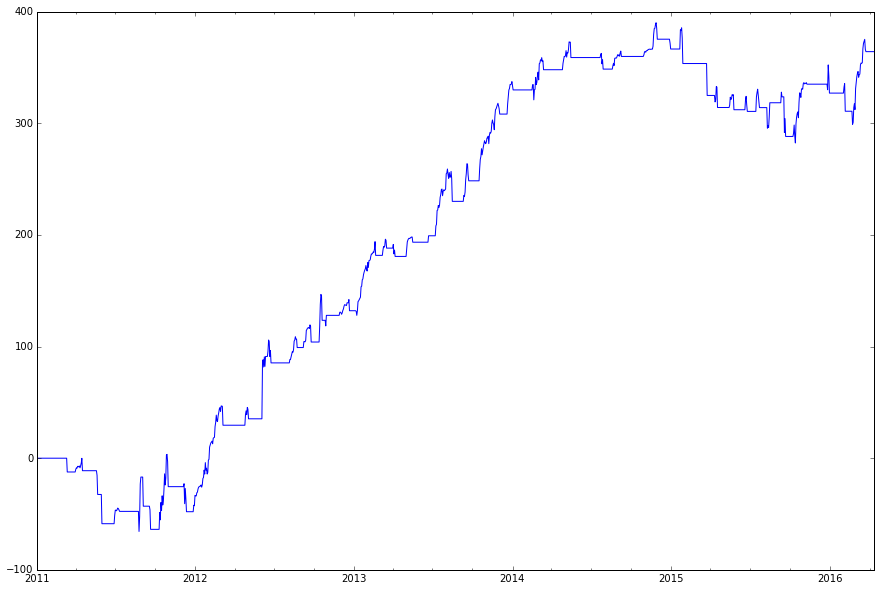

In [112]:
optimizing_period=5

vola_multiplier=0.2

trailing_stop_short = d_slice.exo.rolling(optimizing_period).max().shift(1)

trailing_stop_dynamicsize_short=trailing_stop_short+(volatility_metric*vola_multiplier)

short_entry = CrossDown(fast_ma, slow_ma)
short_exit = (CrossUp(fast_ma, slow_ma)) | (CrossUp(d_slice.exo,trailing_stop_dynamicsize_short))

direction = -1
pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
equity, stats = backtester.stats(pl, inposition)

print(stats)
equity.plot()    

#performance has improved

## Median trailing stop


### Fixed values

In [123]:
#We're going to optimize period of rolling windows, size of TS and compare system perfomance  results
#Index of DF is optimizing parameter value

results_a=[]
results_index_a=[]
results_stop_size_a=[]

for p in range(5,200,5):
    optimizing_period=p
    median_trailstop=d_slice.exo.rolling(p).median().shift(1)
    
    for s in range(0,100,5):
        stop_size=s
        
        short_entry = CrossDown(fast_ma, slow_ma)
        short_exit = (CrossUp(fast_ma, slow_ma)) | (CrossUp(d_slice.exo,median_trailstop+stop_size))

        direction = -1
        pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
        equity, stats = backtester.stats(pl, inposition)

        results_a.append(stats)
        results_index_a.append(p)
        results_stop_size_a.append(stop_size)

In [124]:
median_results_df=pd.DataFrame(results_a,index=[results_index_a,results_stop_size_a])

In [126]:
median_results_df.sort(['netprofit'],ascending=False)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


avg  count   maxdd  netprofit        std   winrate
5   5   6.936170     47 -110.25     326.00  22.626316  0.595745
    10  6.004255     47 -190.40     282.20  26.309550  0.574468
10  0   5.908511     47 -132.55     277.70  25.889393  0.553191
170 5   5.696667     45 -202.25     256.35  30.282210  0.622222
190 5   5.682222     45 -201.40     255.70  29.291738  0.600000
180 0   5.663333     45 -202.25     254.85  30.245511  0.622222
195 0   5.745455     44 -196.10     252.80  30.081538  0.590909
140 10  5.648864     44 -215.00     248.55  29.808723  0.613636
165 0   5.437778     45 -213.05     244.70  30.645774  0.622222
135 10  5.528409     44 -220.30     243.25  29.856120  0.613636
65  20  5.359091     44 -243.10     235.80  29.124221  0.590909
195 5   5.228889     45 -221.80     235.30  29.294919  0.577778
45  0   5.185227     44 -244.60     228.15  30.587307  0.659091
145 15  5.041111     45 -230.30     226.85  29.451586  0.600000
175 5   5.040000     45 -230.30     226.80  30.406486  0.600000
185 5   5.040000     45 -230.30     226.80  30.406486  0.600000
180 5   5.040000     45 -230.30     226.80  30.406486  0.600000
165 5   5.134091     44 -202.25     225.90  30.390975  0.613636
120 20  5.015556     45 -227.45     225.70  29.738361  0.622222
140 15  5.121591     44 -230.30     225.35  29.779490  0.590909
190 0   5.100000     44 -202.25     224.40  30.352943  0.613636
185 0   5.100000     44 -202.25     224.40  30.352943  0.613636
115 20  5.095455     44 -227.45     224.20  30.069622  0.613636
70  25  5.092045     44 -243.10     224.05  29.500917  0.590909
75  25  5.092045     44 -243.10     224.05  29.500917  0.590909
135 15  5.042045     44 -233.80     221.85  29.821215  0.590909
100 0   4.979545     44 -216.85     219.10  29.514433  0.590909
160 0   4.968182     44 -213.05     218.60  30.740995  0.636364
75  10  4.944318     44 -218.65     217.55  29.971824  0.613636
170 0   4.869318     44 -213.05     214.25  30.756568  0.613636
...          ...    ...     ...        ...        ...       ...
195 50  1.845556     45 -328.10      83.05  35.810323  0.600000
140 95  1.762500     44 -328.10      77.55  36.785359  0.613636
145 95  1.762500     44 -328.10      77.55  36.785359  0.613636
25  30  1.598864     44 -287.55      70.35  33.685712  0.568182
20  25  1.585227     44 -310.20      69.75  34.788466  0.545455
10  25  1.577273     44 -352.90      69.40  33.877831  0.522727
190 55  1.563636     44 -328.10      68.80  35.833167  0.613636
185 55  1.563636     44 -328.10      68.80  35.833167  0.613636
195 55  1.563636     44 -328.10      68.80  35.833167  0.613636
45  70  1.530682     44 -339.85      67.35  36.806600  0.613636
    65  1.530682     44 -339.85      67.35  36.806600  0.613636
25  10  1.438636     44 -365.80      63.30  34.661935  0.477273
10  35  1.415909     44 -327.10      62.30  34.788053  0.568182
25  20  1.396591     44 -275.80      61.45  33.467147  0.522727
20  5   1.273913     46 -314.90      58.60  34.103375  0.456522
25  5   1.052273     44 -327.15      46.30  33.161110  0.454545
5   35  1.005682     44 -313.00      44.25  34.513461  0.545455
15  15  1.001136     44 -355.25      44.05  36.145570  0.477273
    5   0.648913     46 -340.55      29.85  32.442748  0.500000
20  20  0.637500     44 -312.75      28.05  33.129452  0.522727
10  20  0.570455     44 -324.90      25.10  35.901165  0.454545
5   30  0.356818     44 -312.95      15.70  33.920116  0.522727
25  25  0.356818     44 -283.35      15.70  34.381186  0.522727
15  20  0.093182     44 -350.50       4.10  34.432915  0.477273
10  15 -0.098889     45 -343.25      -4.45  37.029228  0.466667
    10 -0.130435     46 -342.40      -6.00  31.875673  0.456522
5   25 -0.159091     44 -370.05      -7.00  33.255518  0.500000
20  10 -0.352273     44 -365.70     -15.50  34.963062  0.454545
15  25 -0.810227     44 -373.85     -35.65  35.086577  0.500000
    10 -0.998889     45 -387.75     -44.95  36.381617  0.466667

[780 rows x 6 columns]

{'count': 47, 'winrate': 0.5957446808510638, 'avg': 6.9361702127659965, 'std': 22.626316118126919, 'maxdd': -110.24999999999955, 'netprofit': 326.00000000000182}


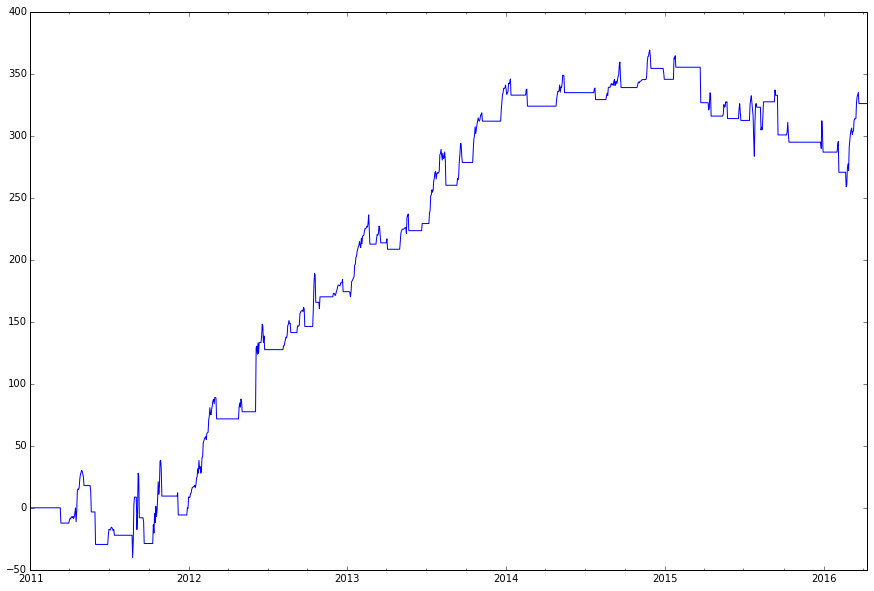

In [127]:
optimizing_period=5
median_trailstop=d_slice.exo.rolling(optimizing_period).median().shift(1)

stop_size=5

short_entry = CrossDown(fast_ma, slow_ma)
short_exit = (CrossUp(fast_ma, slow_ma)) | (CrossUp(d_slice.exo,median_trailstop+stop_size))

direction = -1
pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
equity, stats = backtester.stats(pl, inposition)

print(stats)
equity.plot()    

#Better than rolling max

## Dynamic vola adjusted value 

In [129]:
#We're going to optimize period of rolling windows, size of TS and compare system perfomance  results
#Index of DF is optimizing parameter value

results_a=[]
results_index_a=[]
results_stop_size_a=[]
results_vola_multiplier_a=[]

vola=d_slice.exo.shift(1)-d_slice.exo.shift(2)
volatility_metric=abs(vola.rolling(5).median())


for p in range(5,200,5):
    optimizing_period=p
    median_trailstop=d_slice.exo.rolling(p).median().shift(1)
    
    for s in range(0,100,5):
        stop_size=s
        
        for v in np.arange(0,2,0.1):
            vola_multiplier=v 
            short_entry = CrossDown(fast_ma, slow_ma)
            short_exit = (CrossUp(fast_ma, slow_ma)) | (CrossUp(d_slice.exo,median_trailstop+(stop_size*(volatility_metric*v))))

            direction = -1
            pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
            equity, stats = backtester.stats(pl, inposition)

            results_a.append(stats)
            results_index_a.append(p)
            results_stop_size_a.append(stop_size)
            results_vola_multiplier_a.append(vola_multiplier)

In [132]:
median_dynamicsize_results_df=pd.DataFrame(results_a,index=[results_index_a,results_stop_size_a,results_vola_multiplier_a])
median_dynamicsize_results_df.sort(['netprofit'],ascending=False)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


avg  count   maxdd  netprofit        std   winrate
5   10 0.2  7.742553     47 -112.75     363.90  24.082754  0.617021
    5  0.4  7.742553     47 -112.75     363.90  24.082754  0.617021
    20 0.1  7.742553     47 -112.75     363.90  24.082754  0.617021
    5  0.2  6.504255     47  -98.30     305.70  21.733646  0.595745
    10 0.1  6.504255     47  -98.30     305.70  21.733646  0.595745
    25 0.1  6.324468     47 -154.40     297.25  24.905355  0.595745
    5  0.5  6.324468     47 -154.40     297.25  24.905355  0.595745
140 50 0.1  6.419318     44 -196.10     282.45  28.576389  0.636364
145 25 0.2  6.419318     44 -196.10     282.45  28.576389  0.636364
    10 0.5  6.419318     44 -196.10     282.45  28.576389  0.636364
    5  1.0  6.419318     44 -196.10     282.45  28.576389  0.636364
       0.9  6.419318     44 -196.10     282.45  28.576389  0.636364
    45 0.1  6.419318     44 -196.10     282.45  28.576389  0.636364
    15 0.3  6.419318     44 -196.10     282.45  28.576389  0.636364
140 10 0.5  6.419318     44 -196.10     282.45  28.576389  0.636364
    25 0.2  6.419318     44 -196.10     282.45  28.576389  0.636364
    45 0.1  6.419318     44 -196.10     282.45  28.576389  0.636364
    5  0.9  6.419318     44 -196.10     282.45  28.576389  0.636364
       1.0  6.419318     44 -196.10     282.45  28.576389  0.636364
145 50 0.1  6.419318     44 -196.10     282.45  28.576389  0.636364
140 15 0.3  6.419318     44 -196.10     282.45  28.576389  0.636364
145 70 0.2  6.356818     44 -221.35     279.70  31.611790  0.659091
    20 0.7  6.356818     44 -221.35     279.70  31.611790  0.659091
    10 1.4  6.356818     44 -221.35     279.70  31.611790  0.659091
    35 0.4  6.356818     44 -221.35     279.70  31.611790  0.659091
10  0  1.0  5.908511     47 -132.55     277.70  25.889393  0.553191
    95 0.0  5.908511     47 -132.55     277.70  25.889393  0.553191
    0  0.7  5.908511     47 -132.55     277.70  25.889393  0.553191
       1.3  5.908511     47 -132.55     277.70  25.889393  0.553191
       0.1  5.908511     47 -132.55     277.70  25.889393  0.553191
...              ...    ...     ...        ...        ...       ...
20  5  1.0 -2.136957     46 -368.50     -98.30  31.782499  0.521739
    50 0.1 -2.136957     46 -368.50     -98.30  31.782499  0.521739
    45 0.1 -2.136957     46 -368.50     -98.30  31.782499  0.521739
    25 0.2 -2.136957     46 -368.50     -98.30  31.782499  0.521739
    5  0.8 -2.142391     46 -366.25     -98.55  31.749433  0.521739
    40 0.1 -2.142391     46 -366.25     -98.55  31.749433  0.521739
    10 0.4 -2.142391     46 -366.25     -98.55  31.749433  0.521739
    20 0.2 -2.142391     46 -366.25     -98.55  31.749433  0.521739
    95 0.1 -2.206667     45 -437.30     -99.30  36.723047  0.533333
    5  1.9 -2.206667     45 -437.30     -99.30  36.723047  0.533333
15  10 1.2 -2.227778     45 -410.40    -100.25  35.050016  0.555556
    30 0.4 -2.227778     45 -410.40    -100.25  35.050016  0.555556
    40 0.3 -2.227778     45 -410.40    -100.25  35.050016  0.555556
    15 0.8 -2.227778     45 -410.40    -100.25  35.050016  0.555556
    20 0.6 -2.227778     45 -410.40    -100.25  35.050016  0.555556
    60 0.2 -2.227778     45 -410.40    -100.25  35.050016  0.555556
    15 0.7 -2.341111     45 -427.25    -105.35  36.082562  0.555556
    25 0.4 -2.341111     45 -427.25    -105.35  36.082562  0.555556
    20 0.5 -2.341111     45 -427.25    -105.35  36.082562  0.555556
    50 0.2 -2.341111     45 -427.25    -105.35  36.082562  0.555556
    35 0.3 -2.341111     45 -427.25    -105.35  36.082562  0.555556
    10 1.0 -2.341111     45 -427.25    -105.35  36.082562  0.555556
20  35 0.1 -2.321739     46 -372.30    -106.80  31.836673  0.478261
    5  0.7 -2.321739     46 -372.30    -106.80  31.836673  0.478261
       1.8 -2.978889     45 -437.30    -134.05  36.030624  0.533333
    45 0.2 -2.978889     45 -437.30    -134.05  36.030624  0.533333
    15 0.6 -2.978889     45 -437.30    -134.05  36.030624  0.533333
    9

{'count': 47, 'winrate': 0.6170212765957447, 'avg': 7.7425531914893924, 'std': 24.082754001353806, 'maxdd': -112.74999999999955, 'netprofit': 363.90000000000146}


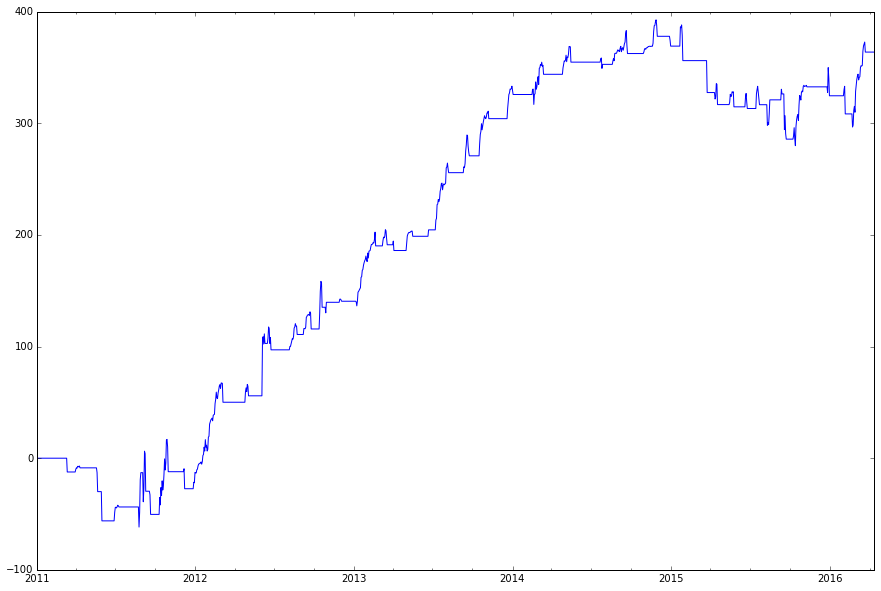

In [133]:
optimizing_period=5
median_trailstop=d_slice.exo.rolling(optimizing_period).median().shift(1)

vola=d_slice.exo.shift(1)-d_slice.exo.shift(2)
volatility_metric=abs(vola.rolling(5).median())

vola_multiplier=0.2

stop_size=10

median_trailstop_dynamic=median_trailstop+(stop_size*(volatility_metric*vola_multiplier))

short_entry = CrossDown(fast_ma, slow_ma)
short_exit = (CrossUp(fast_ma, slow_ma)) | (CrossUp(d_slice.exo,median_trailstop_dynamic))

direction = -1
pl, inposition = backtester.backtest(d_slice, short_entry, short_exit, direction )
equity, stats = backtester.stats(pl, inposition)

print(stats)
equity.plot()    

